In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.contrib import rnn

from sklearn import svm, preprocessing

In [2]:
def neural_network_model(x):

    hl1 = {'w' : tf.Variable(tf.random_normal([dims, n_nodes_hl1])),
           'b' : tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hl2 = {'w' : tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
           'b' : tf.Variable(tf.random_normal([n_nodes_hl2]))}
    
    hl3 = {'w' : tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
           'b' : tf.Variable(tf.random_normal([n_nodes_hl3]))}


    out = {'w' : tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
           'b' : tf.Variable(tf.random_normal([n_classes]))}

    l1 = tf.matmul(x, hl1['w']) + hl1['b']
    l1 = tf.nn.relu(l1)

    l2 = tf.matmul(l1, hl2['w']) + hl2['b']
    l2 = tf.nn.relu(l2)
    
    l3 = tf.matmul(l2, hl3['w']) + hl3['b']
    l3 = tf.nn.relu(l3)

    y = tf.add(tf.matmul(l3, out['w']), out['b'], name='nn')
    return y

def neural_network_model0(input):
    layer = {'w' : tf.Variable(tf.random_normal([num_hidden, n_classes])),
             'b' : tf.Variable(tf.random_normal([n_classes]))}
    
    input = tf.unstack(input, timesteps, 1)    
    
    lstm_cell = rnn.LSTMCell(num_hidden)    
    outs, state = rnn.static_rnn(lstm_cell, input, dtype=tf.float32)
    
    output = tf.add(tf.matmul(outs[-1], layer['w']), layer['b'], name='nn')    
    return output

def train_and_save_nn(x,y):
    nn = neural_network_model(x)
    
    #cost = tf.abs(tf.subtract(nn, y_train), name='cost')
    cost = tf.norm(tf.subtract(nn, y_train), name='cost')
    optimizer = tf.train.AdamOptimizer(0.0006).minimize(cost)   

    saver = tf.train.Saver()
    
    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        epoch_loss = 0
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for i in range(N/batch_size):
                
                epoch_x = X[i*batch_size : (i+1)*batch_size]
                epoch_y = Y[i*batch_size : (i+1)*batch_size]
                
                _, c = session.run([optimizer, cost], feed_dict = {x: epoch_x, y: epoch_y})
                
                #print epoch_x, epoch_y, c, session.run([nn], feed_dict = {x: epoch_x})
                
                epoch_loss += c
                
            if epoch % 100 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss', epoch_loss)
                
        saver.save(session, 'data/fxnn.ckpt')
        
        print('Last epoch loss: ', epoch_loss)
        return nn

In [3]:
X = [] 
Y = []
N = 1000
T_count = int(N*0.2)

XY = []

for i in range(N):
    x = i-N/2
    y = x*x + x*x*x - x
    
    XY.append([x, y])

XY = np.array(XY)
XY = np.reshape(XY, (N,2))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
XY = sc.fit_transform(XY)



from random import randint

TestingSet  = []
TrainingSet = []

#TestingSet.append(XY[0:int(N*0.2)])
for i in range(0,int(N*0.2)):
    TestingSet.append(XY[i])

#TestingSet.append(XY[int(N*0.8):N])
for i in range(int(N*0.8),N):
    TestingSet.append(XY[i])

XY = XY[int(N*0.2):int(N*0.8)]

N = int(N*0.6)

for i in range(N):
    j = randint(0, 1)
    
    if j == 0:
        TrainingSet.append(XY[i])
    else:
        TestingSet.append(XY[i])

T_count = len(TestingSet)
        
#TrainingSet = XY[0:N-T_count]
#TestingSet = XY[N-T_count:N]

TestingSet  = np.array(TestingSet)
TrainingSet = np.array(TrainingSet)

TestingSet  = TestingSet.T
TrainingSet = TrainingSet.T

X = TrainingSet[0]
Y = TrainingSet[1]

X = np.reshape(X, (N-T_count,1))

X_test = TestingSet[0]
Y_test = TestingSet[1]

X_test = np.reshape(X_test, (T_count,1))

print T_count


713


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [4]:
n_nodes_hl1 = 60
n_nodes_hl2 = 30
n_nodes_hl3 = 20

num_hidden = 4

timesteps  = 1
num_input  = 2
step       = num_input * timesteps

dims = 1
n_classes = 1
hm_epochs = 2000
batch_size = 10

x_train = tf.placeholder('float', [None, dims], name='x')
y_train = tf.placeholder('float', name='y')

train_and_save_nn(x_train, y_train)

ValueError: Shape (?,) must have rank 2

INFO:tensorflow:Restoring parameters from data/fxnn.ckpt


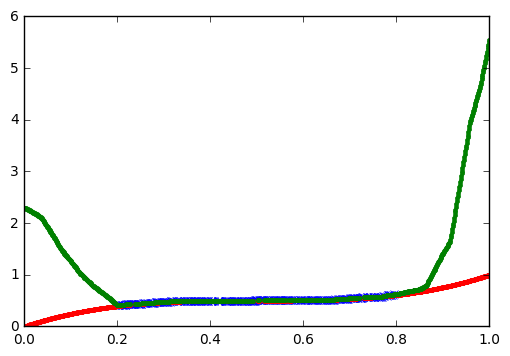

In [5]:
with tf.Session() as session:
    saver = tf.train.import_meta_graph('data/fxnn.ckpt.meta')
    saver.restore(session, tf.train.latest_checkpoint('data/'))

    graph    = tf.get_default_graph()

    x = graph.get_tensor_by_name('x:0')
    y = graph.get_tensor_by_name('y:0')    
    nn = graph.get_tensor_by_name('nn:0')   
    
    P0 = session.run(nn, feed_dict = {x: X})
    P1 = session.run(nn, feed_dict = {x: X_test})
    
    P0 = np.reshape(P0, (N-T_count,))
    P1 = np.reshape(P1, (T_count,))    
        
    plt.plot(X, Y, 'r.')
    plt.plot(X, P0, 'bx')
    plt.plot(X_test, Y_test, 'r.')
    plt.plot(X_test, P1, 'g.')
    plt.show()
    